In [1]:
from client_new import Client
# from client import Client
from server import Server
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
import numpy as np
import gc

## settings are set and client with request and attack traces are created accordingly

In [2]:
FILE_NUM = int(5e3)
TIMESTAMP_NUM = int(1e3)
client = Client(FILE_NUM, TIMESTAMP_NUM)

print('FILE_NUM', FILE_NUM)
print('REQUEST_NUM', TIMESTAMP_NUM)
print('client.file_pool_size', client.file_pool_size)
# pd.DataFrame(client.trace).to_csv('trace_normal.csv')  # 'trace_' + str(np.random.randint(1000)) + '.csv'
# pd.DataFrame(client.trace_with_attack).to_csv('trace_attack.csv')
"""
# fig = plt.figure(figsize=(15, 3))  # LRU
# fig = plt.figure(figsize=(3, 15))  # LFU
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(client.trace, cmap='Greens')
plt.ylabel("time-slots")
plt.xlabel("file id")
plt.title("trace")
plt.show()
"""

total_client_requests: 637314
FILE_NUM 5000
REQUEST_NUM 1000
client.file_pool_size 4994389


'\n# fig = plt.figure(figsize=(15, 3))  # LRU\n# fig = plt.figure(figsize=(3, 15))  # LFU\nfig = plt.figure()\nax = fig.add_subplot(111)\nax.imshow(client.trace, cmap=\'Greens\')\nplt.ylabel("time-slots")\nplt.xlabel("file id")\nplt.title("trace")\nplt.show()\n'

In [3]:
server_hit_rate_dict, server_hit_rate_with_attack_dict = {}, {}
cache_size_array = [1e3, 2e3, 5e3, 1e4, 2e4, 5e4, 1e5, 2e5, 5e5, 1e6]
print('\n' + '#' * 80 + '\n')

hit_rate_stable_for_all = {}


################################################################################



## trace looks like this:

total_client_requests: 12126


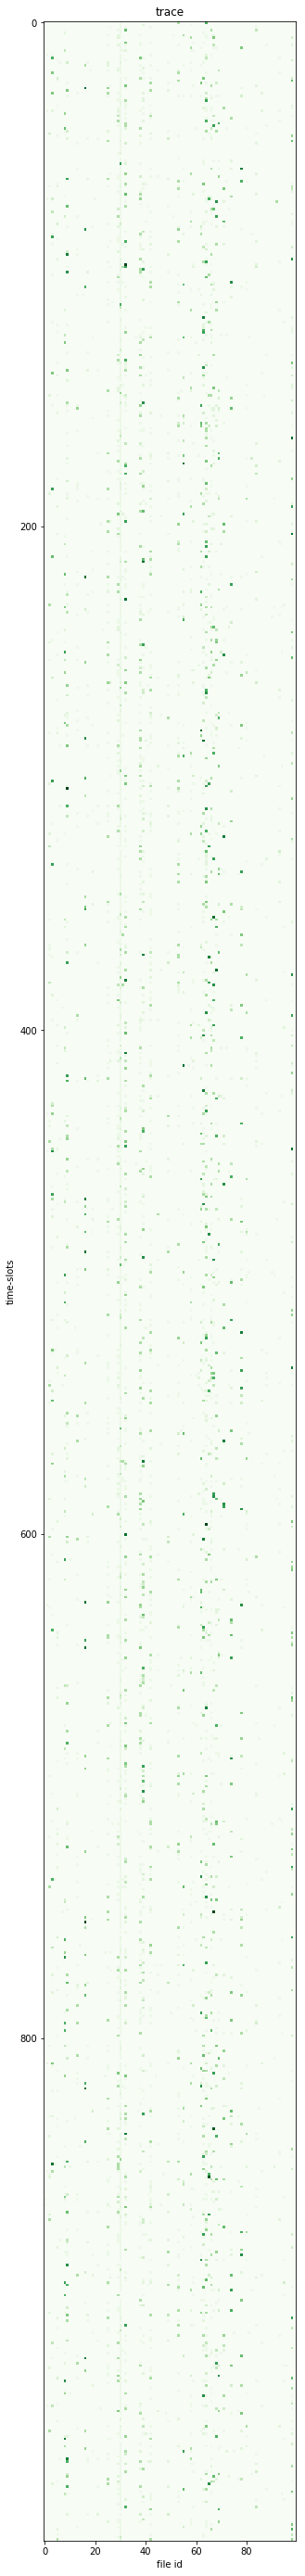

In [29]:
FILE_NUM2 = int(1e2)
TIMESTAMP_NUM2 = int(1e3)
client2 = Client(FILE_NUM2, TIMESTAMP_NUM2)
fig = plt.figure(figsize=(10, 50))
ax = fig.add_subplot(111)
ax.imshow(client2.trace, cmap='Greens')
plt.ylabel("time-slots")
plt.xlabel("file id")
plt.title("trace")
plt.show()

In [4]:
def attack(attack_level):
    server_hit_rate, server_hit_rate_with_attack = [], []
    client.__make_attack_trace__(client.total_attack_requests // client.num_of_time_stamps, attack_level)
    client.total_attack_requests = np.sum(np.sum(client.attack_trace))
    print('total_attack_requests:', client.total_attack_requests)

    # for cache_size in range(client.file_pool_size // 100, client.file_pool_size // 2, client.file_pool_size // 500):
    for cache_size in cache_size_array:
        print('cache_size', cache_size)
        # two identical servers
        server = Server(cache_size, 'LRU')
        server_under_attack = deepcopy(server)

        if cache_size not in hit_rate_stable_for_all:
            hit_rate_stable_for_all[cache_size] = {}

        if not len(server_hit_rate_dict):
            hit_rate_stable = []  # record hit_rate after each file request
            # just normal trace
            for request_file in client.make_requests(client.trace):
                server.handle(request_file)
                hit_rate_stable.append(server.hit_rate())  # record hit_rate after each file request
            hit_rate_stable_for_all[cache_size]['N'] = hit_rate_stable
            server_hit_rate.append(server.hit_rate())
            print('normal:', server_hit_rate[-1])

        # normal trace with attack trace
        trace = client.trace + client.attack_trace
        hit_rate_stable = []  # reset hit_rate_stable
        for request_file in client.make_requests(trace):
            server_under_attack.handle(request_file)
            hit_rate_stable.append(server_under_attack.hit_rate())  # record hit_rate after each file request

        hit_rate_stable_for_all[cache_size][attack_level] = hit_rate_stable
        server_hit_rate_with_attack.append(server_under_attack.hit_rate())
        print('attack:', attack_level, server_hit_rate_with_attack[-1])
    if not len(server_hit_rate_dict):
        server_hit_rate_dict['H'] = server_hit_rate
    server_hit_rate_with_attack_dict[attack_level] = server_hit_rate_with_attack

## start attack

In [5]:
attack_levels = {'H', 'M', 'L', 'LL'}  #
for attack_level in attack_levels:
    attack(attack_level)
    gc.collect()

max_num_requests_for_single_time_stamp: 13.0
total_attack_requests: 6621
cache_size 1000.0
normal: 0.22710155397951157
attack: M 0.22289050878910058
cache_size 2000.0
normal: 0.4029316782576066
attack: M 0.39491252937810095
cache_size 5000.0
normal: 0.6505349001425751
attack: M 0.6392244548918377
cache_size 10000.0
normal: 0.7883727632087593
attack: M 0.7761668479331503
cache_size 20000.0
normal: 0.888511784005197
attack: M 0.8747140613963923
cache_size 50000.0
normal: 0.9406383651690714
attack: M 0.9298500610622965
cache_size 100000.0
normal: 0.9466479616850595
attack: M 0.9360059618812364
cache_size 200000.0
normal: 0.9553814901988948
attack: M 0.9438468153713545
cache_size 500000.0
normal: 0.9754045871024257
attack: M 0.962316070779945
cache_size 1000000.0
normal: 0.9898731222131113
attack: M 0.9781064843841281
max_num_requests_for_single_time_stamp: 1.0
total_attack_requests: 487
cache_size 1000.0
attack: L 0.22597957634751342
cache_size 2000.0
attack: L 0.40189494779422585
cache_s

## hit_rate-changes with cache_size but not so much with attack_level
The effect that hit_rate changes with cache size is significant. However, hit_rate changes less to attack_level (unless H, which is a too high cost for stealthy attacks)

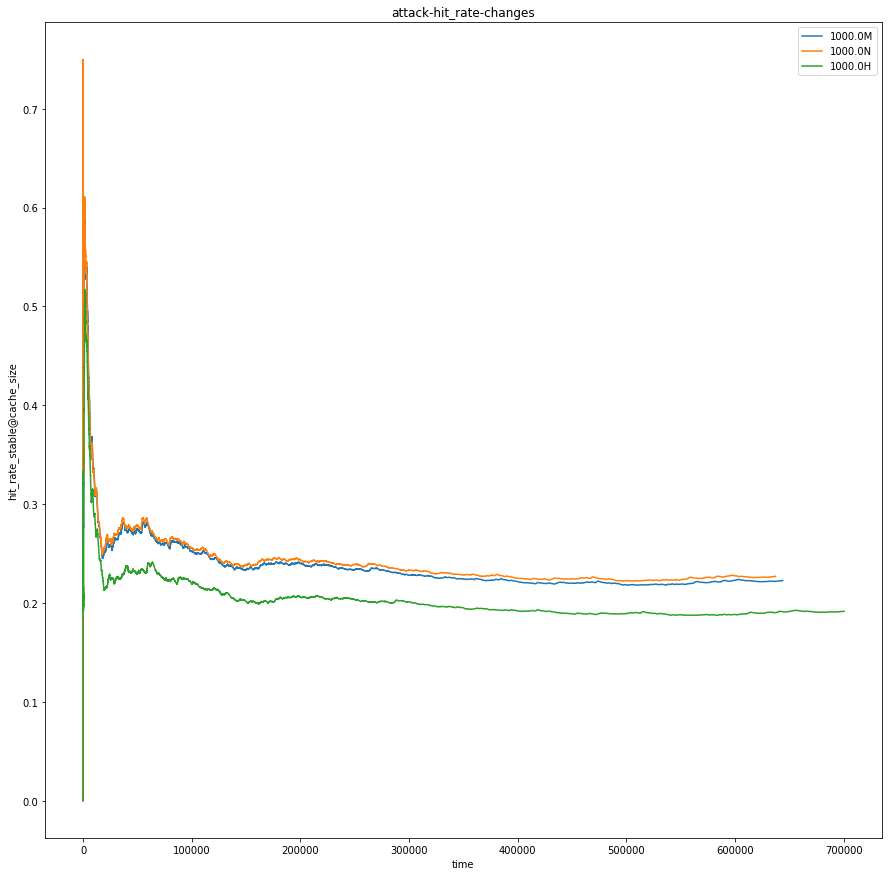

In [14]:
rdi = np.random.randint(0, 100)

plt.figure(figsize=(15, 15))
for cache_size in [1e3]:#[1e3, 1e4, 1e5, 1e6]:
    for attack_level in {'H','M','N'}:
        tmp = hit_rate_stable_for_all[cache_size][attack_level]
        lb = str(cache_size) + attack_level
        plt.plot(range(len(tmp)), tmp, label=lb)
plt.ylabel("hit_rate_stable@cache_size")
plt.xlabel("time")
plt.title("attack-hit_rate-changes")
plt.legend()
# plt.savefig("attack-hit_rate-changes_" + str(rdi) + ".png")
plt.show()

## the decline of hit-rate seems inconspicuous

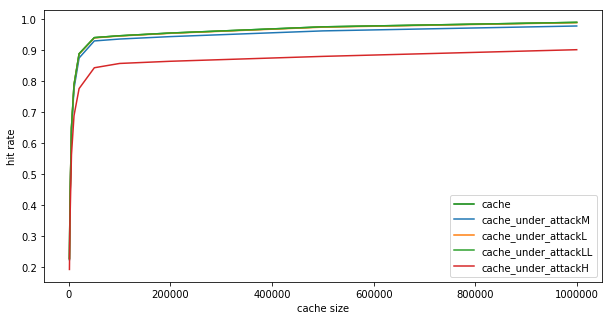

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(cache_size_array, server_hit_rate_dict['H'], color='green', label='cache')
for attack_level in attack_levels:
    plt.plot(cache_size_array, server_hit_rate_with_attack_dict[attack_level],
             label='cache_under_attack' + attack_level)
plt.xlabel("cache size")
plt.ylabel("hit rate")
plt.legend()
# plt.savefig("cache_under_attack_" + str(rdi) + ".png")
plt.show()